## Gated recurrent unit (GRU) 
- faster compute time than LSTM
- replace 3 gates by 2 : reset and update gate
- reset gate: how much of the past information to forget
- update gate: how much of the past information to carry forward to the future
  candidate hidden state: a new hidden state that will be added to the current hidden state
  $$
  \tilde{H}_t = tanh(X_tW_{xh} + (r_t \odot H_{t-1})W_{hh})
  $$
- $R_t$ close to 0: forget the past, 1: keep the past(regular rnn)
$$
H_t = Z_t \odot H_{t-1} + (1 - Z_t) \odot \tilde{H}_t
$$
- $Z_t$ close to 1: retain old state, $X_t$ is ignored.. Z closed to 0: new state state approaches $\tilde{H}_t$

In summary, GRUs have the following two distinguishing features:
- Reset gates help capture short-term dependencies in sequences.
- Update gates help capture long-term dependencies in sequences. 



In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

In [4]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    if H is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                        torch.matmul(H, self.W_hz) + self.b_z)
        R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                        torch.matmul(H, self.W_hr) + self.b_r)
        H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                           torch.matmul(R * H, self.W_hh) + self.b_h)
        H = Z * H + (1 - Z) * H_tilde
        outputs.append(H)
    return outputs, H

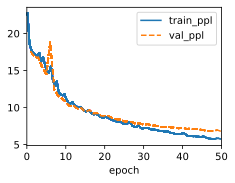

In [6]:
data = d2l.TimeMachine(1024, 32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1)
trainer.fit(model, data)

In [9]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)
    

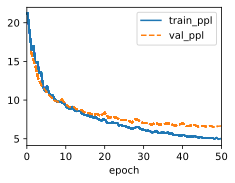

In [10]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [11]:
model.predict("it has", 20, data.vocab, d2l.try_gpu())

'it has i which and the tim'